# Tugas Praktikum

1. Buatlah model SVM dengan menggunakan data voice.csv dengan ketentuan,
    - Split data dengan rasio 70:30 dan 80:20 untuk setiap model yang akan dibangun.
        - Gunakan model dengan kernel linier.
        - Gunakan model dengan kernel polynomial.
        - Gunakan model dengan kernel RBF.
    - Tabulasikan performansi setiap split dan kernel berdasarkan metrik akurasi.

In [14]:
# Import Library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [15]:
# Load Dataset
data = pd.read_csv('E:\\kuliah\\smt5\\voice.csv')
print("Jumlah Data:", data.shape)
print(data.head())

# Preprocessing
# Encode label (male/female -> 0/1)
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

# Pisahkan fitur dan label
X = data.drop('label', axis=1)
y = data['label']

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Jumlah Data: (3168, 21)
   meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3  0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4  0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...  0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...  0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   modindx  label  
0  0.2758

In [16]:
# Fungsi untuk training dan evaluasi model
def train_and_evaluate(kernel, test_size):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled, y, test_size=test_size, random_state=42)
    model = SVC(kernel=kernel)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    acc = accuracy_score(ytest, ypred)
    return acc

In [17]:
# Kernel dan rasio split

results = []

for kernel in ['linear', 'poly', 'rbf']:
    for split in [0.3, 0.2]:
        acc = train_and_evaluate(kernel, split)
        results.append({
            'Kernel': kernel.upper(),
            'Rasio Split': f"{int((1-split)*100)}:{int(split*100)}",
            'Akurasi': round(acc*100, 2)
        })

# Tabel hasil
df_results = pd.DataFrame(results)
print("\n=== Tabel Perbandingan Akurasi ===")
print(df_results)


=== Tabel Perbandingan Akurasi ===
   Kernel Rasio Split  Akurasi
0  LINEAR       70:30    97.06
1  LINEAR       80:20    97.63
2    POLY       70:30    95.69
3    POLY       80:20    96.85
4     RBF       70:30    98.11
5     RBF       80:20    98.26


2. Gunakan data pada praktikum 5 untuk membuat model klasifikasi siang dan malam menggunakan SVM dengan kernel RBF menggunakan fitur histrogram. Gunakan rasio 80:20. Anda dapat bereksperimen dengan hyperparameter tunning dari kernel RBF. Catat performansi akurasinya!

In [23]:
# --- Import Library ---
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

In [24]:
train_dir = 'E:\\kuliah\\smt5\\machine-learning\\images\\training' 

# --- Fungsi load dataset ---
def load_dataset(img_dir):
    p = Path(img_dir)
    dirs = p.glob('*')
    img_list = []

    for dir in dirs:
        label = str(dir).split('/')[-1]
        for file in dir.glob('*.jpg'):
            img = cv2.imread(str(file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img is not None:
                img_list.append((img, label))
    return img_list

In [25]:
# --- Fungsi standarisasi ukuran gambar ---
def standarized_input(image):
    std_img = cv2.resize(image, (256, 256))  # lebih kecil biar efisien
    return std_img

# --- Fungsi encoding label ---
def label_encoder(label):
    label = label.lower()
    if 'day' in label:
        return 1
    elif 'night' in label:
        return 0
    else:
        raise ValueError(f"Unknown label: {label}")


In [26]:
# --- Fungsi preprocess seluruh gambar ---
def preprocess(img_list):
    std_img_list = []
    for img, label in img_list:
        std_img = standarized_input(img)
        encoded_label = label_encoder(label)
        std_img_list.append((std_img, encoded_label))
    return std_img_list

# --- Fungsi ekstraksi fitur histogram warna ---
def extract_histogram_features(img_list):
    features = []
    labels = []
    for img, label in img_list:
        # konversi ke HSV untuk stabilitas warna
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hist = cv2.calcHist([hsv], [0, 1, 2], None, [8,8,8], [0,180,0,256,0,256])
        hist = cv2.normalize(hist, hist).flatten()  # normalisasi dan flatten
        features.append(hist)
        labels.append(label)
    return np.array(features), np.array(labels)

In [28]:
# --- Load dataset ---
all_img = load_dataset(train_dir)
print(f"Total gambar ditemukan: {len(all_img)}")

# --- Preprocess ---
all_std_img = preprocess(all_img)
print(f"Contoh data: {all_std_img[0][0].shape}, label={all_std_img[0][1]}")

# --- Ekstraksi fitur histogram ---
X, y = extract_histogram_features(all_std_img)
print(f"Shape fitur: {X.shape}")

# --- Split 80:20 ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Model SVM RBF dengan GridSearch ---
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 0.01, 0.001]
}

svm_rbf = SVC(kernel='rbf')
grid = GridSearchCV(svm_rbf, param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

print(f"\nBest Params: {grid.best_params_}")
print(f"Best CV Accuracy: {grid.best_score_:.4f}")

Total gambar ditemukan: 240
Contoh data: (256, 256, 3), label=1
Shape fitur: (240, 512)
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Params: {'C': 10, 'gamma': 'scale'}
Best CV Accuracy: 1.0000


Accuracy on Test Data: 0.9792

Classification Report:
              precision    recall  f1-score   support

       Night       0.96      1.00      0.98        24
         Day       1.00      0.96      0.98        24

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48



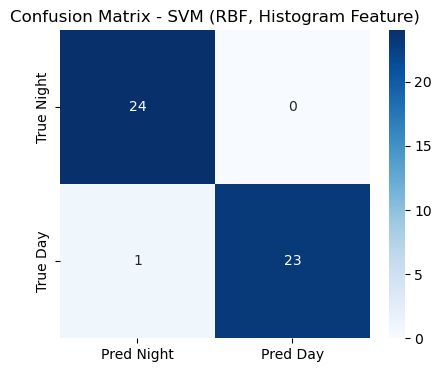

In [31]:
# --- Evaluasi pada Data Uji ---
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Night', 'Day']))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Night', 'Pred Day'],
            yticklabels=['True Night', 'True Day'])
plt.title('Confusion Matrix - SVM (RBF, Histogram Feature)')
plt.show()